In [66]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import s3fs
import intake
import warnings


## Sum/average nr of AR by year?

Functions

In [3]:
def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)
    
def count_2020_ARs(ds, lat_cut):
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))
    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ar_ts = pole_ds.sel(time = ts).ar_binary_tag.squeeze()
        ar_ts = xr.where(ar_ts>1,1,0)
        ll = xr.plot.contour(ar_ts, levels=[0.0,1.0])
        plt.close()
        ar_list = np.array([len(p) for p in ll.collections[0].get_paths()])
        ar_counts[i] = len(ar_list[ar_list>20])
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

def count_ARs(ds, lat_cut):
    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ll = xr.plot.contour(pole_ds.sel(time=ts).ivt, levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts) 
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

In [3]:
AR_2020_file = 'AR_detection_2020.nc4'
data_dir = '/home/jovyan/Tjaernoe2022-group5/data'
ar_2020 = xr.open_dataset(os.path.join(data_dir,AR_2020_file))

In [4]:
daily_2020 = ar_2020.groupby('time.dayofyear').sum()
daily_2020['dayofyear'] =  np.unique(ar_2020.time.dt.floor('D'))
daily_2020 = daily_2020.rename({'dayofyear':'time'})

In [5]:
AR_comp_file = '20002015_AR_detection.nc'
ar_comp = xr.open_dataset(AR_comp_file)

Count ARs:

In [6]:
counted_2020 = count_2020_ARs(daily_2020,60)
counted_2020 = count_2020_ARs(counted_2020,-60)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


In [11]:
counted_comp = count_ARs(ar_comp, 60)
counted_comp = count_ARs(counted_comp, -60)

In [13]:
counted_comp.to_netcdf(AR_comp_file[:-3]+'_counted.nc')
counted_2020.to_netcdf(AR_2020_file[:-4]+'_counted.nc')

In [30]:
print(counted_comp.ar_counts_60.sum()/15)
print(counted_2020.ar_counts_60.sum())

<xarray.DataArray 'ar_counts_60' ()>
array(286.2)
<xarray.DataArray 'ar_counts_60' ()>
array(253.)


In [31]:
print(counted_comp['ar_counts_-60'].sum()/15)
print(counted_2020['ar_counts_-60'].sum())

<xarray.DataArray 'ar_counts_-60' ()>
array(260.13333333)
<xarray.DataArray 'ar_counts_-60' ()>
array(258.)


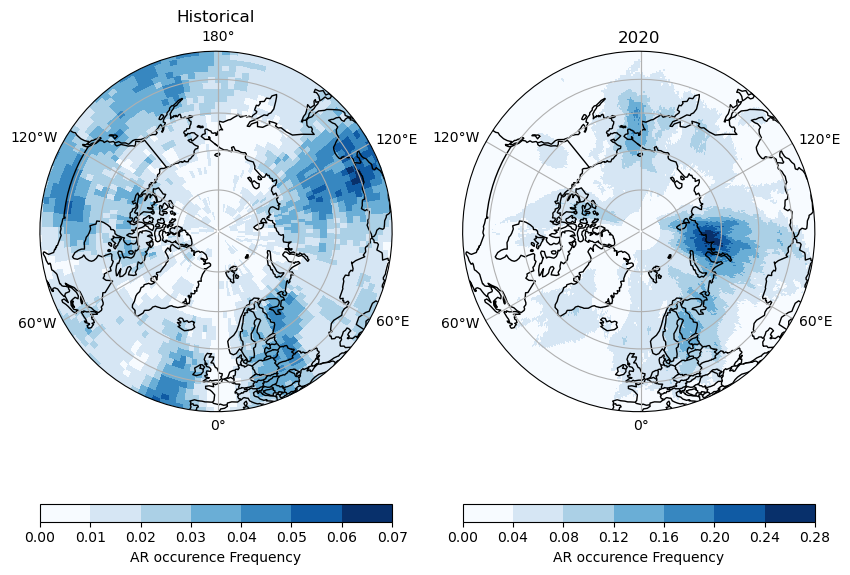

In [51]:
f,ax = plt.subplots(1,2,dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
counted_comp.sel(lat=slice(40,90), time=slice('2011-01-01','2011-12-31')).ivt.mean(dim='time').plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[0],
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
counted_2020.ar_binary_tag.mean(dim='time').plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[1],
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',     
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
for a in ax:
    a.coastlines()
    circle_for_polar_map(a)
    a.set_extent([0, 360, 40, 90], ccrs.PlateCarree())
    gl = a.gridlines(draw_labels=True)
    a.add_feature(cy.feature.BORDERS)
    
ax[0].set_title('Historical')
ax[1].set_title('2020')

gl.top_labels = False
gl.right_labels = False

plt.show()

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
#s3.ls('escience2022/Remy/')

In [3]:
s3path_hist1_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20000101-20091231.nc'
s3path_hist2_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20100101-20141231.nc'

hist1_aod = xr.open_dataset(s3.open(s3path_hist1_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])
hist2_aod = xr.open_dataset(s3.open(s3path_hist2_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])

In [4]:
start_year='2000'
end_year='2015'

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [6]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['clt','pr','tas'], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]]
hist_vars = dset.sel(member_id='r1i1p1f1',time=slice(str(start_year)+"-01-01", str(end_year)+"-01-01"))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
ar_hist = xr.open_dataset('20002015_AR_detection_counted.nc')

In [8]:
aod_hist = xr.merge([hist1_aod, hist2_aod])

In [9]:
aod_hist.od550aer.min()

<xarray.DataArray 'od550aer' ()>
array(1.00121486)
Coordinates:
    wavelength  float64 550.0

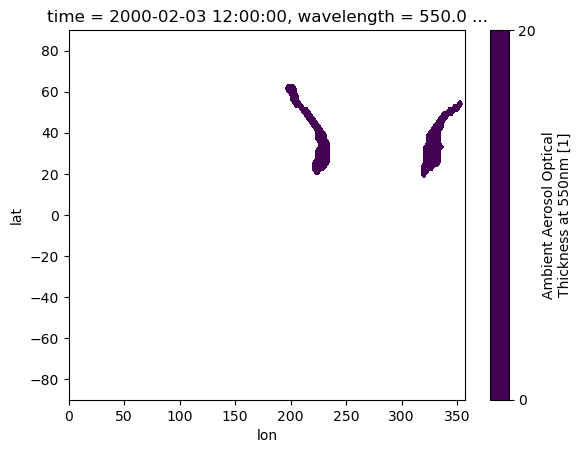

In [32]:
ll = xr.plot.contourf(aod_hist.where(ar_hist.ivt==True).sel(time='2000-02-03').od550aer.squeeze(), levels=[0,20])

In [69]:
def sort_ar_by_aod(aod_ds,ar_ds):
    warnings.simplefilter('ignore', UserWarning)
    aod_ar=aod_ds.where(ar_ds.ivt==True)
    clean_lim = aod_ar.od550aer.median()
    aod_ar['poll_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    aod_ar['clean_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    for ts in aod_ar.time:
        ts_array = aod_ar.sel(time=ts).od550aer
        ll = xr.plot.contourf(ts_array.squeeze(), levels=[0,20])
        plt.close()
        for i,item in enumerate(ll.collections[0].get_paths()):
            v = item.vertices
            lat = v[:,1]
            lon = v[:,0]
            ar_i_aod = ts_array.sel(lat=slice(np.min(lat), np.max(lat)), lon = slice(np.min(lon), np.max(lon)))
            if ar_i_aod.mean(skipna=True)>clean_lim:
                aod_ar['poll_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
            else:
                aod_ar['clean_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
    return aod_ar

    
def average_in_box(array, lon, lat):
    avg = array.sel(lat=slice(np.min(lat),np.max(lat)), lon = slice(np.min(lon),np.max(lon))).mean(skipna=True)
    return avg

In [22]:
test_aod=aod_hist.sel(time=slice('2000-02-01','2000-02-04'), lat=slice(0,90))
test_ar=ar_hist.sel(time=slice('2000-02-01','2000-02-04'), lat=slice(0,90))

In [23]:
t=sort_ar_by_aod(test_aod,test_ar)

In [70]:
aod_ar_hist = sort_ar_by_aod(aod_hist.sel(lat=slice(0,90)), ar_hist.sel(lat=slice(0,90)))

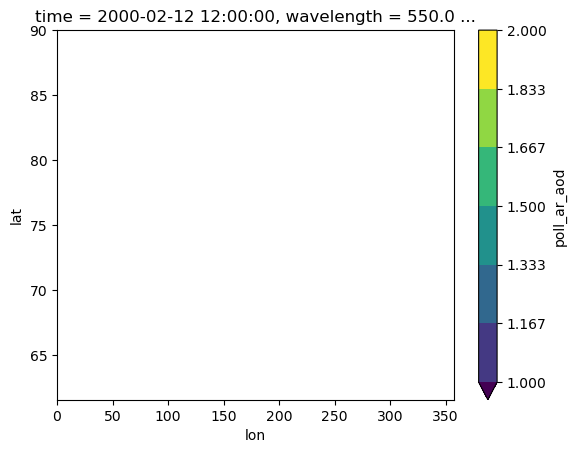

In [116]:
#xr.plot.contourf(aod_ar_hist.sel(time='2000-02-01')['clean_ar_aod'].squeeze(), vmin=1, vmax=2)
xr.plot.contourf(aod_ar_hist.sel(time='2000-02-12', lat=slice(60,90))['poll_ar_aod'].squeeze(), vmin=1, vmax=2)

In [93]:
hist_poll_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_hist.poll_ar_aod.notnull() )
hist_clean_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_hist.clean_ar_aod.notnull() )

In [17]:
#hist_poll_ar = hist_vars.where(aod_ar_hist.od550aer>aod_ar_hist.od550aer.quantile(0.75),drop=True)

In [18]:
#hist_clean_ar = hist_vars.where(aod_ar_hist.od550aer<aod_ar_hist.od550aer.quantile(0.25),drop=True)

In [75]:
clean_clt = hist_clean_ar.clt.values.flatten()[~np.isnan(hist_clean_ar.clt.values.flatten())]
poll_clt = hist_poll_ar.clt.values.flatten()[~np.isnan(hist_poll_ar.clt.values.flatten())]

In [76]:
clean_pr = hist_clean_ar.pr.values.flatten()[~np.isnan(hist_clean_ar.pr.values.flatten())]
poll_pr = hist_poll_ar.pr.values.flatten()[~np.isnan(hist_poll_ar.pr.values.flatten())]

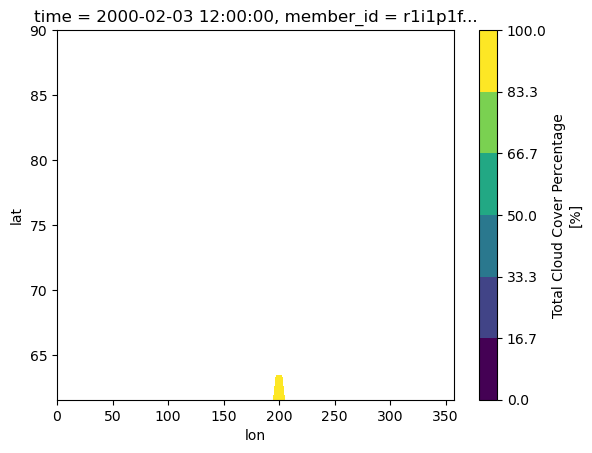

In [104]:
xr.plot.contourf(hist_poll_ar.sel(time='2000-02-03')['clt'].squeeze(), vmin=0, vmax=100)

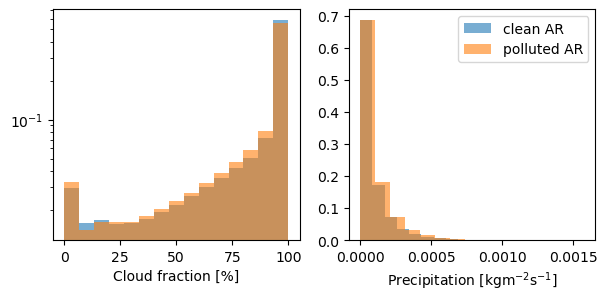

In [81]:
fig, axs = plt.subplots(1,2,dpi=100, figsize=(7,3))

axs[0].hist(clean_clt, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_clt) + 1. / clean_clt.size)
axs[0].hist(poll_clt,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_clt) + 1. / poll_clt.size)

axs[1].hist(clean_pr, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_pr) + 1. / clean_pr.size)
axs[1].hist(poll_pr,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_pr) + 1. / poll_pr.size)

axs[0].set_xlabel('Cloud fraction [%]')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')

axs[0].set_yscale('log')
#axs[1].set_yscale('log')
plt.legend()
plt.show()

In [45]:
aod_hist['ar']=ar_hist.ivt

In [ ]:
hist_vars

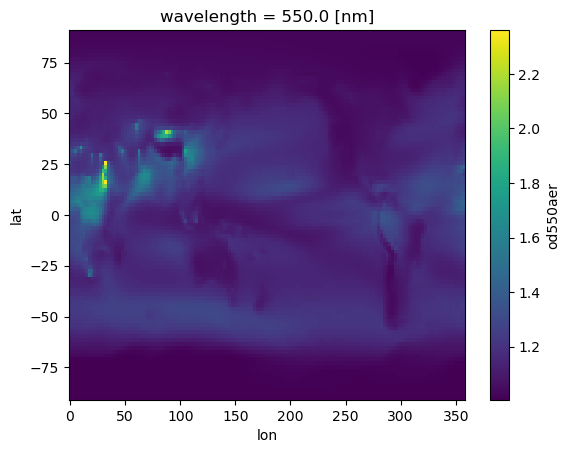

In [72]:
aod_hist.od550aer.mean(dim='time').plot.pcolormesh()

In [74]:
aod_hist.od550aer.min()

<xarray.DataArray 'od550aer' ()>
array(1.00121486)
Coordinates:
    wavelength  float64 550.0